# MRMC Basic Results

In [13]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '../../..'))

%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from sklearn import neighbors
from sklearn import model_selection
import KDEpy

import matplotlib.pyplot as plt
import seaborn as sns
from models import model_interface, model_loader, model_constants
from data import data_loader
from data.adapters import continuous_adapter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Preliminaries -- load everything

In [14]:
DATASET, DATASET_INFO = data_loader.load_data(data_loader.DatasetName('credit_card_default'))
MODEL = model_loader.load_model(model_constants.ModelType('logistic_regression'), data_loader.DatasetName('credit_card_default'))
ADAPTER = continuous_adapter.StandardizingAdapter(
    label_column = DATASET_INFO.label_column, positive_label=DATASET_INFO.positive_label
).fit(DATASET)

cluster_df = pd.read_csv('./cluster_df.csv')
index_df = pd.read_csv('./index_df.csv')
path_df = pd.read_csv('./path_df.csv')
index_df

/home/jakeval/umass/research/.venv/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 1.1.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/jakeval/umass/research/.venv/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.1.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


,batch_id,run_id,run_seed,cluster_seed,confidence_cutoff,dataset_name,max_iterations,model_type,noise_ratio,num_paths,rescale_ratio,step_size,volcano_cutoff,volcano_degree
0,9,272,1701,1834823,0.8,credit_card_default,30,logistic_regression,NaN,3,NaN,1,0.5,2
1,8,269,227,1834823,0.8,credit_card_default,30,logistic_regression,NaN,2,NaN,1,0.5,2
2,14,421,3183,1834823,0.9,credit_card_default,30,logistic_regression,NaN,4,NaN,1,0.5,2
3,10,316,5500,1834823,0.8,credit_card_default,30,logistic_regression,NaN,4,NaN,1,0.5,2
4,12,362,1701,1834823,0.9,credit_card_default,30,logistic_regression,NaN,2,NaN,1,0.5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,14,434,51,1834823,0.9,credit_card_default,30,logistic_regression,NaN,4,NaN,1,0.5,2
476,8,267,1393,1834823,0.8,credit_card_default,30,logistic_regression,NaN,2,NaN,1,0.5,2
477,14,447,1393,1834823,0.9,credit_card_default,30,logistic_regression,NaN,4,NaN,1,0.5,2
478,11,331,3183,1834823,0.8,credit_card_default,30,logistic_regression,NaN,5,NaN,1,0.5,2


## Fit a KDE

In [23]:
kfold = model_selection.KFold(n_splits=5)
transformed_data = ADAPTER.transform(DATASET.drop(columns='Y')).sample(frac=1, replace=False)

bandwidths = np.logspace(-1, 0, 6)
scores = []

for bw in bandwidths:
    print("Evaluate bandwidth", bw)
    score = 0
    for train_indices, val_indices in kfold.split(transformed_data):
        kde = neighbors.KernelDensity(bandwidth=bw).fit(transformed_data.iloc[train_indices])
        score += kde.score(transformed_data.iloc[val_indices])
    scores.append(score / len(bandwidths))
    print(scores[-1])
best_bandwidth = bandwidths[np.argmax(scores)]
print("Finished! Selected bandwidth is ", best_bandwidth)
KDE = neighbors.KernelDensity(bandwidth=bw).fit(transformed_data)
print("Scoring full dataset...")
scores = KDE.score_samples(transformed_data)

Evaluate bandwidth 0.1
-239505.59410350616
Evaluate bandwidth 0.15848931924611134
-79518.12250062286
Evaluate bandwidth 0.251188643150958
-45343.77261743743
Evaluate bandwidth 0.3981071705534973
-56178.50274111767
Evaluate bandwidth 0.6309573444801934
-82751.69123600908
Evaluate bandwidth 1.0
-116706.0182975628


### Evaluate the KDE qualitatively

The scores are between -28 and -20. Unsurprisingly, most points have relatively high density.
Overall the histogram seems reasonable.

,density
count,30000.000000
mean,-22.843568
std,2.389319
min,-28.687723
25%,-24.448342
50%,-22.099292
75%,-20.776036
max,-20.143852


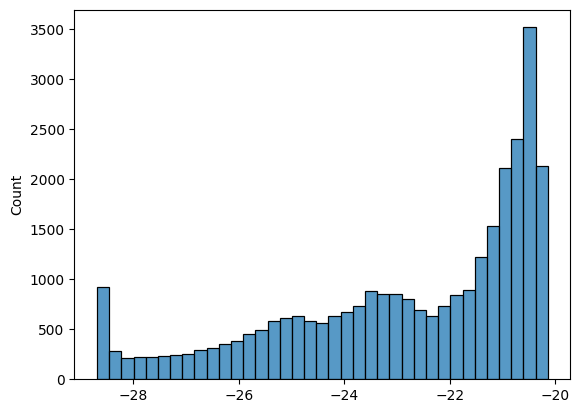

In [37]:
best_bandwidth = bandwidths[np.argmax(scores)]
KDE = neighbors.KernelDensity(bandwidth=bw).fit(transformed_data)
KDE_SCORES = KDE.score_samples(transformed_data)
sns.histplot(KDE_SCORES)
pd.DataFrame({'density': KDE_SCORES}).describe()

In [40]:
def get_path_length(path):
    path = ADAPTER.transform(path)
    if len(path) == 1:
        return np.nan
    length = 0
    for i in range(1, len(path)):
        diff = path.iloc[i] - path.iloc[i-1]
        length += np.linalg.norm(diff.to_numpy())
    return length


def get_final_density(path):
    return KDE.score_samples(ADAPTER.transform(path.iloc[-1:]))


def analyze_paths(paths, target_certainty):
    metrics = {
        'success_ratio': 0,
    }
    path_lengths = []
    cfe_densities = []
    for i, path in enumerate(paths):
        if MODEL.predict_pos_proba_series(path.iloc[-1]) > target_certainty:
            metrics['success_ratio'] += 1
        path_length = get_path_length(path)
        metrics[f'path_{i}_length'] = path_length
        if not np.isnan(path_length):
            path_lengths.append(path_length)
        cfe_densities.append(get_final_density(path))
     
    metrics['path_length'] = np.mean(path_lengths)
    metrics['success_ratio'] = metrics['success_ratio'] / len(paths)
    metrics['min_density'] = np.min(cfe_densities)
    return metrics


def aggregate_metrics(run_metrics):
    aggregated_metrics = {}
    for metrics in run_metrics:
        for metric, metric_value in metrics.items():
            aggregated_metrics[metric] = aggregated_metrics.get(metric, []) + [metric_value]
    
    return pd.DataFrame(aggregated_metrics)


def analyze_runs(runs: pd.DataFrame, target_certainty, num_paths):
    """Analyze a batch of runs sharing the same configuration values and return aggregated results over the full batch."""
    run_metrics = []
    for run_id in runs.run_id.unique():
        paths = []
        run = runs[runs.run_id == run_id]
        for path_id in range(num_paths):
            path = run[run.path_id == path_id].sort_values(['step_id']).drop(columns=['batch_id', 'run_id', 'step_id', 'path_id'])
            paths.append(path)
        run_metrics.append(analyze_paths(paths, target_certainty))
    return aggregate_metrics(run_metrics)

# Analyze the results. This will take a while...
Expect about 5-10 minutes.


Metrics are collected per-run. So for example, we will get a dataframe with a column 'success_ratio'
which lists the ratio of paths which crossed the decision boundary in that specific run.

In [41]:
final_results = None

batch_ids = index_df.batch_id.unique()

for i, batch_id in enumerate(batch_ids):
    print(f"Process batch {i+1}/{len(batch_ids)}")
    batched_runs = path_df[path_df.batch_id == batch_id]  # get all runs in a batch
    # get some metadata data about the batch -- we'll need it later
    target_certainty = index_df[index_df.batch_id == batch_id].confidence_cutoff.iloc[0]
    num_paths = index_df[index_df.batch_id == batch_id].num_paths.iloc[0]

    metrics_df = analyze_runs(batched_runs, target_certainty, num_paths)
    metrics_df['batch_id'] = batch_id
    if final_results is not None:
        final_results = pd.concat([final_results, metrics_df]).reset_index(drop=True)
    else:
        final_results = metrics_df

Process batch 1/16
Process batch 2/16
Process batch 3/16
Process batch 4/16
Process batch 5/16
Process batch 6/16
Process batch 7/16
Process batch 8/16
Process batch 9/16
Process batch 10/16
Process batch 11/16
Process batch 12/16
Process batch 13/16
Process batch 14/16
Process batch 15/16
Process batch 16/16


# Let's look at the average metrics across the full batch

The results are hard to interpret when viewed per-run. Here we average over all runs
in a given batch.

We see that the results are fairly stable -- the average success ratio is high.

Interpreting the columns:
* path_k_length: The average sum of euclidean distances between each sequential point of the recourse path
* path_length: The average over path_k_length
* success_ratio: The average ratio of paths which crossed the decision boundary.
* min_density: Before averaging over the batch, this column is the minimum kde density of the counterfactuals returned by the recourse method across one run. We then average over all min_density values in a batch. This metric should be reconsidered -- it's confusing that it's an
average of minimums.



Takeaways:
* path_length is low but needs more analysis
* min_density is reasonable but needs more analysis
* As we increase confidence_cutoff, both path_length and min_density "worsen" (increase/decrease respectively)


In [42]:
mean_results = final_results.groupby('batch_id').mean().sort_values('success_ratio')
mean_results = pd.merge(mean_results, index_df[['batch_id', 'num_paths', 'confidence_cutoff']], on='batch_id').drop_duplicates('batch_id')
mean_results.sort_values('path_length')

,batch_id,success_ratio,path_0_length,path_1_length,path_2_length,path_length,min_density,path_3_length,path_4_length,num_paths,confidence_cutoff
30,1,1.0,4.433333,3.866667,3.766667,4.022222,-25.177516,NaN,NaN,3,0.6
0,0,1.0,3.866667,4.400000,NaN,4.133333,-22.339699,NaN,NaN,2,0.6
60,2,1.0,3.866667,5.566667,3.833333,4.316667,-24.957889,4.000000,NaN,4,0.6
90,3,1.0,3.833333,4.000000,6.500000,4.753333,-34.939363,5.566667,3.866667,5,0.6
120,4,1.0,4.633333,6.466667,NaN,5.550000,-23.192621,NaN,NaN,2,0.7
180,6,1.0,4.666667,6.766667,8.066667,6.041667,-36.137441,4.666667,NaN,4,0.7
210,7,1.0,4.666667,6.800000,4.600000,6.260000,-36.658931,8.066667,7.166667,5,0.7
150,5,1.0,6.433333,4.633333,8.066667,6.377778,-36.114216,NaN,NaN,3,0.7
270,9,1.0,5.733333,7.933333,10.633333,8.100000,-39.375320,NaN,NaN,3,0.8
240,8,1.0,5.733333,10.633333,NaN,8.183333,-38.862602,NaN,NaN,2,0.8


# Let's see examples of path lengths

In [49]:
def get_paths(batch_id, path_df):
    run_id = path_df[path_df.batch_id == batch_id].run_id.sample(1).iloc[0]
    selected_paths = path_df[(path_df.run_id == run_id)]
    paths = []
    for path_id in selected_paths.sort_values('path_id').path_id.unique():
        paths.append(selected_paths[selected_paths.path_id == path_id])
    return paths

## Short paths

Less than 4 units long on average

In [69]:

# select a random short path -- less than length 4
short_batch_id = final_results[final_results.path_length < 4].iloc[0].batch_id

short_path = get_paths(short_batch_id, path_df)[0]

print("Path length", get_path_length(short_path))

print("\nPATH START:\n")
print(short_path.iloc[0])
print("\nPATH END:\n")
print(short_path.iloc[-1])

Path length 5.656854249492381

PATH START:

LIMIT_BAL    50000.0
AGE             29.0
PAY_1            0.0
PAY_2            0.0
PAY_3            0.0
PAY_4            0.0
PAY_5            0.0
PAY_6            0.0
BILL_AMT1    27179.0
BILL_AMT2    27878.0
BILL_AMT3    28908.0
BILL_AMT4    29922.0
BILL_AMT5    30517.0
BILL_AMT6    31164.0
PAY_AMT1      1454.0
PAY_AMT2      1484.0
PAY_AMT3      1498.0
PAY_AMT4      1093.0
PAY_AMT5      1139.0
PAY_AMT6      2039.0
step_id          0.0
path_id          0.0
run_id         241.0
batch_id         8.0
Name: 2513, dtype: float64

PATH END:

LIMIT_BAL    346457.908632
AGE              34.264911
PAY_1             0.002397
PAY_2             0.001146
PAY_3             0.003092
PAY_4             0.006450
PAY_5             0.001177
PAY_6             0.003751
BILL_AMT1     42056.443298
BILL_AMT2     56769.000526
BILL_AMT3     59460.815457
BILL_AMT4     51250.779906
BILL_AMT5     48694.306553
BILL_AMT6     45920.533163
PAY_AMT1      39139.629246
PAY_AMT2

## Medium paths

Around 8 units long

In [70]:
medium_batch_id = final_results[(final_results.path_length > 7.8) & (final_results.path_length < 8)].iloc[0].batch_id
medium_path = get_paths(medium_batch_id, path_df)[0]

print("Path length", get_path_length(medium_path))

print("\nPATH START:\n")
print(medium_path.iloc[0])
print("\nPATH END:\n")
print(medium_path.iloc[-1])

Path length 9.899494936611667

PATH START:

LIMIT_BAL    60000.0
AGE             40.0
PAY_1            0.0
PAY_2            0.0
PAY_3            0.0
PAY_4            0.0
PAY_5            0.0
PAY_6            0.0
BILL_AMT1    28738.0
BILL_AMT2    30216.0
BILL_AMT3    23720.0
BILL_AMT4     1569.0
BILL_AMT5     5580.0
BILL_AMT6     2211.0
PAY_AMT1      4000.0
PAY_AMT2      1010.0
PAY_AMT3      1569.0
PAY_AMT4      5580.0
PAY_AMT5      2211.0
PAY_AMT6         0.0
step_id          0.0
path_id          0.0
run_id         385.0
batch_id        12.0
Name: 10115, dtype: float64

PATH END:

LIMIT_BAL    331006.269786
AGE              37.918573
PAY_1             0.011891
PAY_2             0.001167
PAY_3             0.009942
PAY_4             0.000000
PAY_5             0.010996
PAY_6             0.013170
BILL_AMT1     53564.780561
BILL_AMT2    104401.744415
BILL_AMT3    104198.776747
BILL_AMT4     87014.229700
BILL_AMT5     78783.461133
BILL_AMT6     73204.120096
PAY_AMT1      87875.478485
PAY_AMT

## Long paths

Around 15 units long on average

In [66]:
long_batch_id = final_results[(final_results.path_length > 15)].iloc[0].batch_id
long_path = get_paths(long_batch_id, path_df)[2]

print("Path length", get_path_length(long_path))
print("\nPATH START:\n")
print(long_path.iloc[0])
print("\nPATH END:\n")
print(long_path.iloc[-1])

Path length 28.28427124746191

PATH START:

LIMIT_BAL    60000.0
AGE             36.0
PAY_1            1.0
PAY_2            2.0
PAY_3            2.0
PAY_4            2.0
PAY_5            2.0
PAY_6            2.0
BILL_AMT1    28504.0
BILL_AMT2    27747.0
BILL_AMT3    32577.0
BILL_AMT4    31754.0
BILL_AMT5    34228.0
BILL_AMT6    35128.0
PAY_AMT1         0.0
PAY_AMT2      5300.0
PAY_AMT3         0.0
PAY_AMT4      3000.0
PAY_AMT5      1600.0
PAY_AMT6      1000.0
step_id          0.0
path_id          2.0
run_id         444.0
batch_id        14.0
Name: 1144, dtype: float64

PATH END:

LIMIT_BAL    461480.716599
AGE              37.829138
PAY_1             0.070094
PAY_2             0.140187
PAY_3             0.155288
PAY_4             0.140187
PAY_5             0.140187
PAY_6             0.140187
BILL_AMT1    157992.364961
BILL_AMT2     58389.594977
BILL_AMT3     51092.848131
BILL_AMT4    312544.657528
BILL_AMT5    274794.257879
BILL_AMT6    257975.524892
PAY_AMT1      24893.686138
PAY_AMT2

# Interpreting KDE scores

In [ ]:
scores = KDE.score_samples(ADAPTER.transform(DATASET.drop(columns='Y')))

sns.histplot(scores)
print("Minimum is", np.min(scores))
print("Maximum is", np.min(scores))
print("Average is", np.mean(scores))

So the KDE scores returned by STEP are on the low side. How bad is this?